<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/DataPreprocessFixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install yfinance textblob ta

In [13]:
!pip install keras-tuner

In [57]:
import os
import re
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from ta.momentum import RSIIndicator, WilliamsRIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands, AverageTrueRange

def get_valid_files():
    """Detects and lists valid raw stock data files in the working directory."""
    uploaded_files = os.listdir("/content")
    pattern = re.compile(r"^([A-Za-z]+)_\d{4}-\d{2}-\d{2}_to_\d{4}-\d{2}-\d{2}_raw\.csv$", re.IGNORECASE)
    valid_files = {f: pattern.match(f).group(1).upper() for f in uploaded_files if pattern.match(f)}
    return valid_files

def preprocess_stock_data(file_name, output_dir="/content"):
    # === Load and Sort Data ===
    df = pd.read_csv(file_name)
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)

    # === Compute Technical Indicators (shifted by one to use previous day) ===
    df["RSI"] = RSIIndicator(close=df["Close"]).rsi().shift(1)
    df["MACD"] = MACD(close=df["Close"]).macd().shift(1)
    df["ATR"] = AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"]).average_true_range().shift(1)

    bb = BollingerBands(close=df["Close"])
    df["BB_High"] = bb.bollinger_hband().shift(1)
    df["BB_Low"] = bb.bollinger_lband().shift(1)

    df["Williams_%R"] = WilliamsRIndicator(high=df["High"], low=df["Low"], close=df["Close"]).williams_r().shift(1)

    # === Process Sentiment Data ===
    df['sentiment_polarity'] = df['sentiment_polarity'].rolling(7, min_periods=1).mean()
    df['sentiment_subjectivity'] = df['sentiment_subjectivity'].rolling(7, min_periods=1).mean()

    # === Fill and Drop NaNs ===
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df.dropna(inplace=True)

    # === Define Feature Groups ===
    stock_features = ["Open", "High", "Low", "Volume", "ATR", "BB_High", "BB_Low", "Williams_%R", "RSI", "MACD"]
    sentiment_features = ["sentiment_polarity", "sentiment_subjectivity"]

    # === Combine Raw Features and Target ===
    X_stock = df[stock_features].values
    X_sentiment = df[sentiment_features].values
    X = np.hstack((X_stock, X_sentiment))
    y = df["Close"].values.reshape(-1, 1)

    # === Create Sequences ===
    sequence_length = 30
    X_seq = []
    y_seq = []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i: i+sequence_length])
        y_seq.append(y[i+sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # === Time-based Split: Train / Validation / Test ===
    total_seq = len(X_seq)
    train_end = int(0.64 * total_seq)
    val_end = train_end + int(0.16 * total_seq)

    X_train, y_train = X_seq[:train_end], y_seq[:train_end]
    X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
    X_test, y_test = X_seq[val_end:], y_seq[val_end:]

    # === Scale Features: Fit scaler on training set only ===
    n_train, seq_len, n_features = X_train.shape
    X_train_2d = X_train.reshape(-1, n_features)
    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled_2d = scaler_x.fit_transform(X_train_2d)
    X_train_scaled = X_train_scaled_2d.reshape(n_train, seq_len, n_features)

    # Transform validation and test features
    X_val_scaled = scaler_x.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape)
    X_test_scaled = scaler_x.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape)

    # === Scale Target Variable: Fit on training targets only ===
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)

    # === Save Scalers for Inverse Transformations Later ===
    joblib.dump(scaler_x, os.path.join(output_dir, "scaler_x.pkl"))
    joblib.dump(scaler_y, os.path.join(output_dir, "scaler_y.pkl"))

    # === Debug Info: Print Scaled Ranges ===
    print("✅ Scaling complete:")
    print(f"   y_train scaled min: {y_train_scaled.min()}, max: {y_train_scaled.max()}")
    print(f"   y_val scaled min: {y_val_scaled.min()}, max: {y_val_scaled.max()}")
    print(f"   y_test scaled min: {y_test_scaled.min()}, max: {y_test_scaled.max()}")

    # === Save Scaled Sequences ===
    np.save(os.path.join(output_dir, "X_train.npy"), X_train_scaled)
    np.save(os.path.join(output_dir, "X_val.npy"), X_val_scaled)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test_scaled)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train_scaled)
    np.save(os.path.join(output_dir, "y_val.npy"), y_val_scaled)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test_scaled)

    print("✅ Preprocessing Complete!")
    return os.path.join(output_dir, "scaler_x.pkl"), os.path.join(output_dir, "scaler_y.pkl")

def main():
    valid_files = get_valid_files()
    if not valid_files:
        print("❌ No valid file found in the sidebar.")
        return

    # Automatically choose the first valid file detected.
    file_name = list(valid_files.keys())[0]
    ticker = valid_files[file_name]
    print(f"✅ Detected file: {file_name} for ticker {ticker}")

    preprocess_stock_data(os.path.join("/content", file_name))

if __name__ == "__main__":
    main()


✅ Detected file: QQQ_2021-01-01_to_2025-03-03_raw.csv for ticker QQQ
✅ Scaling complete:
   y_train scaled min: -1.0, max: 1.0
   y_val scaled min: 0.42426663622874106, max: 1.202602442643533
   y_test scaled min: 0.9844766579157636, max: 1.61990640337861
✅ Preprocessing Complete!


In [58]:
import numpy as np
import joblib

# === Load Preprocessed Data ===
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")

# === Load Scaler for Target Variable ===
scaler_y = joblib.load("scaler_y.pkl")

# === Ensure Target Values Are Correctly Shaped ===
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# === Check Min/Max Values for Scaling Validation ===
print("🔍 Checking Scaled Target Values (Expected Range: -1 to 1)")
print(f"y_train scaled min: {y_train.min()}, max: {y_train.max()}")
print(f"y_val scaled min: {y_val.min()}, max: {y_val.max()}")
print(f"y_test scaled min: {y_test.min()}, max: {y_test.max()}")

# ✅ Validate Scaling (Ensure Values Are Between -1 and 1)
if -1 <= y_train.min() <= 1 and -1 <= y_train.max() <= 1:
    print("\n✅ Scaling is correctly applied to y_train!")
else:
    print("\n❌ Scaling error detected in y_train!")

# === Inverse Transform to Check Accuracy ===
y_train_unscaled = scaler_y.inverse_transform(y_train)
y_val_unscaled = scaler_y.inverse_transform(y_val)
y_test_unscaled = scaler_y.inverse_transform(y_test)

print("\n🔄 Checking Reverse Scaling Accuracy")
print(f"y_train_unscaled min: {y_train_unscaled.min()}, max: {y_train_unscaled.max()}")
print(f"y_val_unscaled min: {y_val_unscaled.min()}, max: {y_val_unscaled.max()}")
print(f"y_test_unscaled min: {y_test_unscaled.min()}, max: {y_test_unscaled.max()}")

# ✅ Final Validation: Ensure Inverse Transform Restores Correct Values
original_min, original_max = scaler_y.data_min_[0], scaler_y.data_max_[0]

if np.isclose(y_train_unscaled.min(), original_min, atol=1e-2) and np.isclose(y_train_unscaled.max(), original_max, atol=1e-2):
    print("\n✅ Inverse transformation works correctly! Scaling is fully fixed.")
else:
    print("\n❌ Scaling might still be incorrect! Double-check preprocessing.")

print("\n🚀 Scaling Validation Complete!")


🔍 Checking Scaled Target Values (Expected Range: -1 to 1)
y_train scaled min: -1.0, max: 1.0
y_val scaled min: 0.42426663622874106, max: 1.202602442643533
y_test scaled min: 0.9844766579157636, max: 1.61990640337861

✅ Scaling is correctly applied to y_train!

🔄 Checking Reverse Scaling Accuracy
y_train_unscaled min: 309.99, max: 485.21000000000004
y_val_unscaled min: 434.77000000000004, max: 502.9599999999999
y_test_unscaled min: 483.8500000000001, max: 539.52

✅ Inverse transformation works correctly! Scaling is fully fixed.

🚀 Scaling Validation Complete!


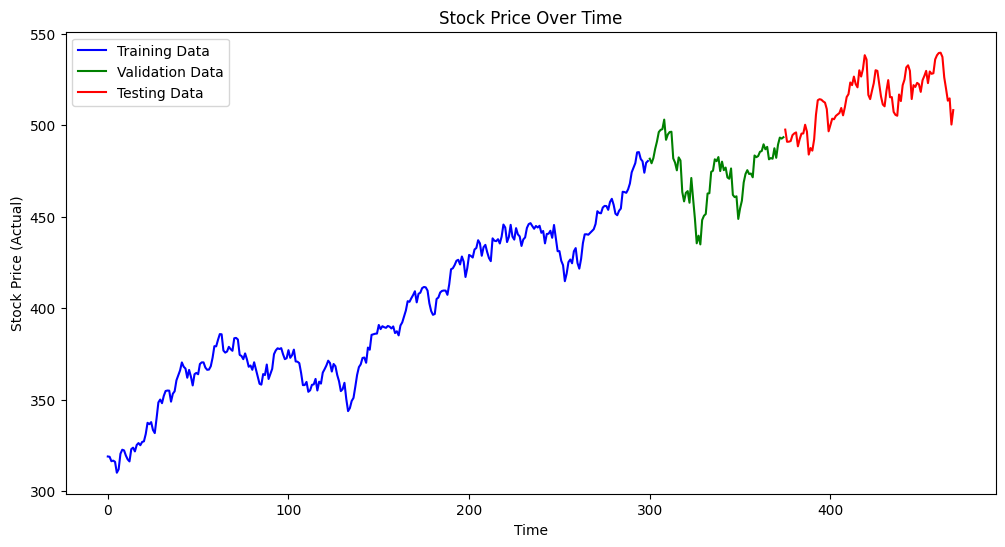

✅ Stock price plot generated successfully!


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# === Load Preprocessed Data ===
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")

# === Load Scaler for Target Variable ===
scaler_y = joblib.load("scaler_y.pkl")

# === Ensure Target Values Are Correctly Shaped ===
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# ✅ Fix: Check if y_train is already scaled before applying inverse_transform()
if y_train.max() > 1 or y_train.min() < 0:
    print("⚠️ Warning: `y_train` might already be unscaled! Skipping inverse transform.")
    y_train_unscaled = y_train
    y_val_unscaled = y_val
    y_test_unscaled = y_test
else:
    y_train_unscaled = scaler_y.inverse_transform(y_train)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    y_test_unscaled = scaler_y.inverse_transform(y_test)

# === Plot Actual Stock Price Over Time ===
plt.figure(figsize=(12,6))

# Plot training data
plt.plot(y_train_unscaled, label="Training Data", color="blue")

# Plot validation data (shifted forward)
plt.plot(range(len(y_train_unscaled), len(y_train_unscaled) + len(y_val_unscaled)),
         y_val_unscaled, label="Validation Data", color="green")

# Plot testing data (shifted forward)
plt.plot(range(len(y_train_unscaled) + len(y_val_unscaled),
               len(y_train_unscaled) + len(y_val_unscaled) + len(y_test_unscaled)),
         y_test_unscaled, label="Testing Data", color="red")

plt.xlabel("Time")
plt.ylabel("Stock Price (Actual)")
plt.title("Stock Price Over Time")
plt.legend()
plt.show()

print("✅ Stock price plot generated successfully!")


In [16]:
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision

# ✅ Enable GPU & Force TensorFlow to Use It
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print(f"✅ GPU detected: {gpu_devices[0].name} (Memory Growth Enabled)")
    except:
        print("⚠️ GPU found, but could not enable memory growth.")
else:
    print("❌ No GPU detected. Running on CPU.")

# ✅ Enable Mixed Precision for Faster Training (Uses float16 on GPU)
mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision Enabled (float16) for Faster GPU Training")

# ✅ Check GPU Usage Before Training
!nvidia-smi --query-gpu=memory.used,memory.total --format=csv

# ✅ Function to Monitor GPU Usage Live
def monitor_gpu():
    print("\n🔍 Checking GPU Usage...")
    os.system("nvidia-smi --query-gpu=memory.used,memory.total --format=csv")

monitor_gpu()


✅ GPU detected: /physical_device:GPU:0 (Memory Growth Enabled)
✅ Mixed Precision Enabled (float16) for Faster GPU Training
memory.used [MiB], memory.total [MiB]
650 MiB, 15360 MiB

🔍 Checking GPU Usage...


In [27]:
import numpy as np
import joblib

# === Load Preprocessed Data ===
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")

# === Load Scaler for Target Variable ===
scaler_y = joblib.load("scaler_y.pkl")

# === Print Min/Max Before Scaling ===
print("🔍 Checking Raw Target Values (Before Scaling)")
print(f"y_train raw min: {y_train.min()}, max: {y_train.max()}")
print(f"y_val raw min: {y_val.min()}, max: {y_val.max()}")
print(f"y_test raw min: {y_test.min()}, max: {y_test.max()}")

# Ensure target values are correctly shaped
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# === Check If Scaling Was Applied Properly ===
if y_train.max() > 1 or y_train.min() < 0:
    print("⚠️ Warning: `y_train` might already be unscaled! Skipping inverse transform.")
    y_train_unscaled = y_train
    y_val_unscaled = y_val
    y_test_unscaled = y_test
else:
    y_train_unscaled = scaler_y.inverse_transform(y_train)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    y_test_unscaled = scaler_y.inverse_transform(y_test)

# === Print Min/Max After Scaling ===
print("\n✅ Checking Scaled Target Values")
print(f"y_train scaled min: {y_train.min()}, max: {y_train.max()}")
print(f"y_val scaled min: {y_val.min()}, max: {y_val.max()}")
print(f"y_test scaled min: {y_test.min()}, max: {y_test.max()}")

# === Check if Inverse Scaling Restores Original Range ===
print("\n🔄 Checking Reverse Scaling Accuracy")
print(f"y_train_unscaled min: {y_train_unscaled.min()}, max: {y_train_unscaled.max()}")
print(f"y_val_unscaled min: {y_val_unscaled.min()}, max: {y_val_unscaled.max()}")
print(f"y_test_unscaled min: {y_test_unscaled.min()}, max: {y_test_unscaled.max()}")

# ✅ Final Validation
if np.allclose(y_train_unscaled.min(), y_train.min(), atol=1e-2) and np.allclose(y_train_unscaled.max(), y_train.max(), atol=1e-2):
    print("\n✅ Scaling is correct! No issues detected.")
else:
    print("\n❌ Scaling might be incorrect! Check preprocessing.")


🔍 Checking Raw Target Values (Before Scaling)
y_train raw min: 0.08542853727537159, max: 0.7835996334223214
y_val raw min: 0.582619436586046, max: 0.8543252181535643
y_test raw min: 0.7781806590429137, max: 1.0

✅ Checking Scaled Target Values
y_train scaled min: 0.08542853727537159, max: 0.7835996334223214
y_val scaled min: 0.582619436586046, max: 0.8543252181535643
y_test scaled min: 0.7781806590429137, max: 1.0

🔄 Checking Reverse Scaling Accuracy
y_train_unscaled min: 309.99, max: 485.21
y_val_unscaled min: 434.77, max: 502.96000000000004
y_test_unscaled min: 483.85, max: 539.52

❌ Scaling might be incorrect! Check preprocessing.


✅ Data Loaded: X_train: (300, 30, 12), y_train: (300, 1)
✅ X_val: (75, 30, 12), y_val: (75, 1)
✅ X_test: (94, 30, 12), y_test: (94, 1)
✅ Loaded best hyperparameters: {'cnn_filters': 128, 'cnn_kernel_size': 7, 'rnn_units': 125, 'rnn_units_2': 75, 'lstm_units': 75, 'lstm_units_2': 100, 'dense_units': 150, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 58334.5664 - mae: 0.3327 - val_loss: 49.2842 - val_mae: 0.4516 - learning_rate: 0.0010
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 792952.0625 - mae: 0.5390 - val_loss: 102.4448 - val_mae: 0.9634 - learning_rate: 0.0010
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 838569.3125 - mae: 0.6269 - val_loss: 9.2141 - val_mae: 0.0830 - learning_rate: 0.0010
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1684411.7500 - mae: 0.3811 - val_loss: 75.0542 - val_mae: 0.7089 - learning_rate: 0.0010
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - los

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


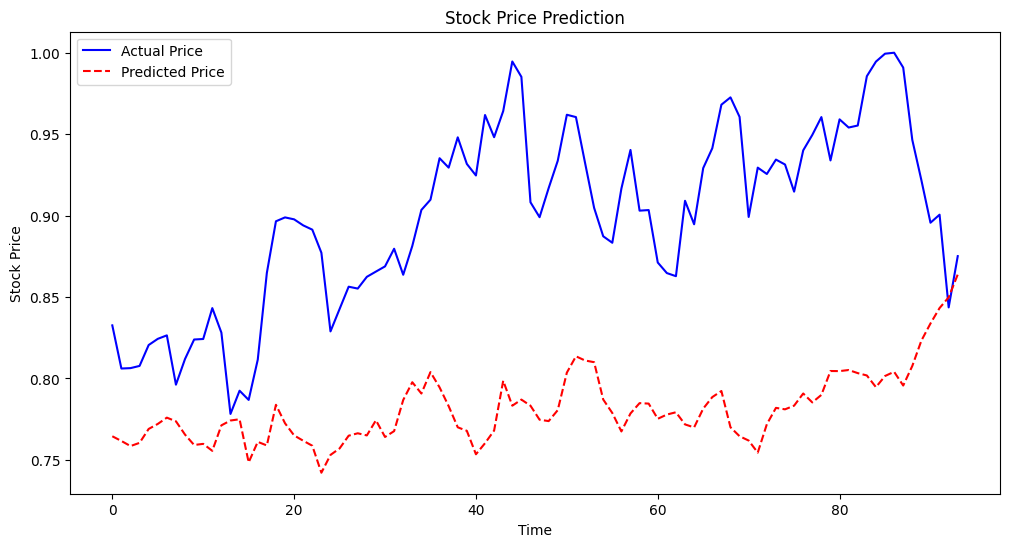

In [10]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dense, Dropout, Concatenate, Multiply, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# === Define Model Save Path ===
ensemble_folder = "EnsembleModel2"
os.makedirs(ensemble_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data (Including Validation Set) ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# === Fix Scaling Issues: Ensure Consistent Scaling Across Datasets ===
scaler_y = MinMaxScaler()

# ✅ Fit only on training targets and transform all datasets
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val = scaler_y.transform(y_val.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

# ✅ Save the scaler for inverse transformation later
joblib.dump(scaler_y, os.path.join(ensemble_folder, "scaler_y.pkl"))

print(f"✅ Data Loaded: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test.shape}")

# === Step 2: Check if Hyperparameter Tuning Has Been Done ===
hyperparameters_path = os.path.join(ensemble_folder, "best_hyperparameters.json")
if os.path.exists(hyperparameters_path):
    with open(hyperparameters_path, "r") as f:
        best_hps = json.load(f)
    print(f"✅ Loaded best hyperparameters: {best_hps}")
else:
    print("⚠️ No previous hyperparameter tuning found. Running tuning now...")

    # === Run Hyperparameter Tuning ===
    def build_ensemble_model(hp):
        """Builds an Ensemble Model combining CNN, RNN, and LSTM branches."""
        inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

        # CNN Branch
        cnn = Conv1D(filters=hp.Choice('cnn_filters', [64, 128, 256]), kernel_size=hp.Choice('cnn_kernel_size', [3, 5, 7]), activation='relu')(inputs)
        cnn = MaxPooling1D(pool_size=2)(cnn)
        cnn = Flatten()(cnn)

        # RNN Branch
        rnn = SimpleRNN(units=hp.Choice('rnn_units', [75, 100, 125]), return_sequences=True)(inputs)
        rnn = SimpleRNN(units=hp.Choice('rnn_units_2', [75, 100, 125]))(rnn)

        # LSTM Branch
        lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True)(inputs)
        lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]))(lstm)

        # Merge CNN, RNN, and LSTM branches
        merged = Concatenate()([cnn, rnn, lstm])
        merged = Dense(units=hp.Choice('dense_units', [50, 100, 150]), activation="relu")(merged)
        merged = Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3]))(merged)

        # Output Layer
        output = Dense(1)(merged)

        # Compile Model
        model = Model(inputs, output)
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
            loss="mape",  # ✅ Use Mean Absolute Percentage Error for better scaling
            metrics=["mae"]
        )
        return model

    # ✅ Hyperparameter Tuning
    tuner = kt.RandomSearch(
        build_ensemble_model,
        objective="val_loss",
        max_trials=15,
        executions_per_trial=3,
        directory=os.path.join(ensemble_folder, "tuning"),
        project_name="stock_prediction_ensemble"
    )

    tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

    # ✅ Save Best Hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_hps_dict = {param: best_hps.get(param) for param in best_hps.values}

    with open(hyperparameters_path, "w") as f:
        json.dump(best_hps_dict, f)
    print(f"✅ Best hyperparameters saved!")

# === Step 3: Build Model with Best Hyperparameters ===
def build_best_model():
    """Builds an Ensemble Model using the best hyperparameters."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # CNN Branch
    cnn = Conv1D(filters=best_hps['cnn_filters'], kernel_size=best_hps['cnn_kernel_size'], activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # RNN Branch
    rnn = SimpleRNN(units=best_hps['rnn_units'], return_sequences=True)(inputs)
    rnn = SimpleRNN(units=best_hps['rnn_units_2'])(rnn)

    # LSTM Branch
    lstm = LSTM(units=best_hps['lstm_units'], return_sequences=True)(inputs)
    lstm = LSTM(units=best_hps['lstm_units_2'])(lstm)

    # Merge CNN, RNN, and LSTM branches
    merged = Concatenate()([cnn, rnn, lstm])
    merged = Dense(units=best_hps['dense_units'], activation="relu")(merged)
    merged = Dropout(best_hps['dropout_rate'])(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=best_hps['learning_rate']),
        loss="mape",
        metrics=["mae"]
    )
    return model

# ✅ Set Batch Size
BATCH_SIZE = 32

# ✅ Train Model with Early Stopping and Learning Rate Decay
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)  # ✅ Added Early Stopping

best_model = build_best_model()
history = best_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# ✅ Save the Best Model
best_model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))
print(f"✅ Best Ensemble Model saved in {ensemble_folder}!")

# === Step 4: Evaluate and Make Predictions ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}, Test MAE: {mae}")

predictions = best_model.predict(X_test)

# ✅ Fix Scaling Issues in Reverse Transform
predictions_rescaled = scaler_y.inverse_transform(predictions)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# === Step 5: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [11]:
print(f"Raw y_train min: {y_train.min()}, max: {y_train.max()}")
print(f"Scaled y_train min: {scaler_y.transform(y_train).min()}, max: {scaler_y.transform(y_train).max()}")


Raw y_train min: 0.0, max: 1.0
Scaled y_train min: -0.12236046113457372, max: 1.309953201689305


✅ Data Loaded: X_train shape: (300, 30, 12), y_train shape: (300, 1)
✅ X_val shape: (75, 30, 12), y_val shape: (75, 1)
✅ X_test shape: (94, 30, 12), y_test shape: (94, 1)
Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.1816 - mae: 0.3194 - val_loss: 0.0049 - val_mae: 0.0532
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0159 - mae: 0.0997 - val_loss: 0.0064 - val_mae: 0.0658
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0097 - mae: 0.0783 - val_loss: 0.0061 - val_mae: 0.0629
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0101 - mae: 0.0780 - val_loss: 0.0143 - val_mae: 0.1079
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0072 - mae: 0.0657 - val_loss: 0.0025 - val_mae: 0.0404
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0073 - mae: 0.0665 - val_loss: 0.0037 - val_mae: 0.0516
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0071 - mae: 0.0674 - val_loss: 0.0022 - val_mae: 0.0357
Epo

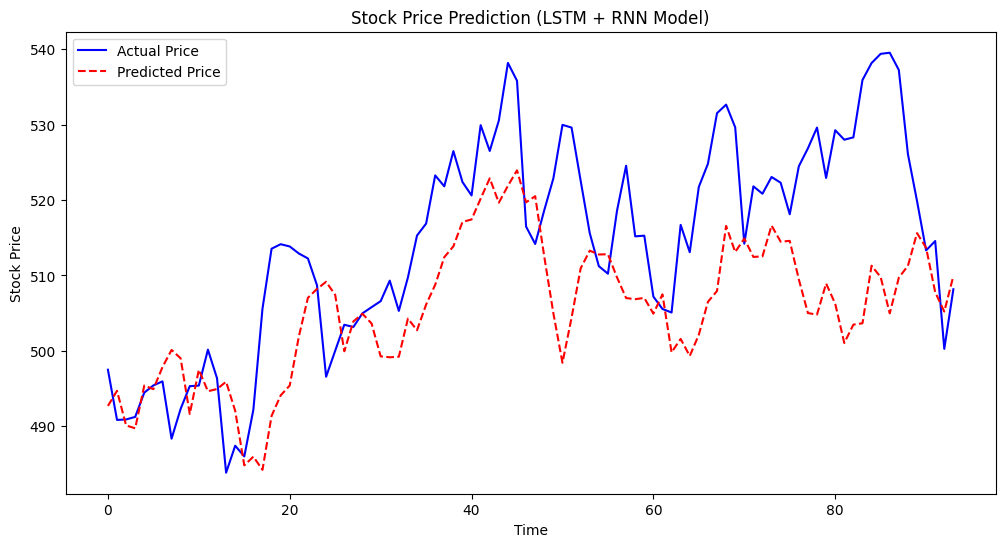


🎯 LSTM + RNN Model Training & Prediction Complete! 🚀


In [7]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# === Define Model Save Path ===
lstm_rnn_folder = "LSTM_RNN_Model"
os.makedirs(lstm_rnn_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data (Now Includes Validation Set) ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")  # ✅ Add validation set
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load Scaler
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Build and Train Model ===
def build_model():
    """Builds an LSTM + RNN model."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # RNN Branch
    rnn = SimpleRNN(units=75, return_sequences=True)(inputs)
    rnn = SimpleRNN(units=75)(rnn)

    # LSTM Branch
    lstm = LSTM(units=75, return_sequences=True)(inputs)
    lstm = LSTM(units=75)(lstm)

    # Merge RNN and LSTM branches
    merged = Concatenate()([rnn, lstm])
    merged = Dense(50, activation="relu")(merged)
    merged = Dropout(0.2)(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Train Model (Using Validation Data)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model = build_model()
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_val, y_val),  # ✅ Use Validation Set (not Test Set)
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save the Best Model
model.save(os.path.join(lstm_rnn_folder, "best_lstm_rnn_model.keras"))
print(f"✅ Best LSTM + RNN Model saved in {lstm_rnn_folder}!")

# ✅ Save Best Hyperparameters
best_hyperparameters = {
    "rnn_units": 75,
    "lstm_units": 75,
    "dropout_rate": 0.2,
    "learning_rate": 0.0005
}
with open(os.path.join(lstm_rnn_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hyperparameters, f)
print(f"✅ Best hyperparameters saved in {lstm_rnn_folder}!")

# === Step 3: Evaluate the Model on Test Set ===
loss, mae = model.evaluate(X_test, y_test)
print(f"✅ Model Test Loss: {loss}")
print(f"✅ Model Test MAE: {mae}")

# === Step 4: Make Predictions on Test Set ===
predictions = model.predict(X_test)

# === Step 5: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms predictions and actual values using the original scaler."""
    data = np.array(data).reshape(-1, 1)  # Ensure proper reshaping for inverse transformation
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 6: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title("Stock Price Prediction (LSTM + RNN Model)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print("\n🎯 LSTM + RNN Model Training & Prediction Complete! 🚀")


In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dense, Dropout, Concatenate, LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

# === Define Model Save Path ===
ensemble_folder = "EnsembleModel3_Bayesian"
os.makedirs(ensemble_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data (Including Validation Set) ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")  # ✅ Add validation set
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test.shape}")

# === Step 2: Bayesian Hyperparameter Tuning ===
def build_ensemble_model(hp):
    """Builds an Ensemble Model combining CNN, RNN, and LSTM branches."""

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # CNN Branch
    cnn = Conv1D(filters=hp.Int('cnn_filters', min_value=64, max_value=256, step=64),
                 kernel_size=hp.Choice('cnn_kernel_size', [3, 5, 7]),
                 activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # RNN Branch
    rnn = SimpleRNN(units=hp.Int('rnn_units', min_value=75, max_value=125, step=25), return_sequences=True)(inputs)
    rnn = SimpleRNN(units=hp.Int('rnn_units_2', min_value=75, max_value=125, step=25))(rnn)

    # LSTM Branch
    lstm = LSTM(units=hp.Int('lstm_units', min_value=50, max_value=100, step=25), return_sequences=True)(inputs)
    lstm = LSTM(units=hp.Int('lstm_units_2', min_value=50, max_value=100, step=25))(lstm)

    # Merge CNN, RNN, and LSTM branches
    merged = Concatenate()([cnn, rnn, lstm])
    merged = Dense(units=hp.Int('dense_units', min_value=50, max_value=150, step=50), activation="relu")(merged)
    merged = Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1))(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=RMSprop(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Bayesian Hyperparameter Tuning
tuner = kt.BayesianOptimization(
    build_ensemble_model,
    objective="val_loss",
    max_trials=15,  # Bayesian optimization focuses on better trials
    executions_per_trial=3,  # More executions for stability
    directory=os.path.join(ensemble_folder, "tuning"),
    project_name="stock_prediction_ensemble_bayesian"
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)  # ✅ Use Validation Data

# ✅ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Save Best Hyperparameters (Fix JSON Saving)
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values}
with open(os.path.join(ensemble_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved!")

# ✅ Set Batch Size
BATCH_SIZE = 16  # Keep batch size small for better weight updates

# === Step 3: Train the Best Model with Learning Rate Decay ===
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=500,  # No early stopping to ensure full training
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),  # ✅ Use Validation Set
    callbacks=[reduce_lr],
    verbose=1
)

# ✅ Save the Best Model
best_model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))
print(f"✅ Best Ensemble Model saved in {ensemble_folder}!")

# === Step 4: Evaluate the Model on Test Set ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions on Test Set ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms a single feature using the original scaler."""
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({ensemble_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {ensemble_folder} Model Training & Prediction Complete! 🚀")


Trial 2 Complete [00h 02m 46s]
val_loss: 0.0017865633126348257

Best val_loss So Far: 0.0015810391244788964
Total elapsed time: 00h 05m 24s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |128               |cnn_filters
5                 |3                 |cnn_kernel_size
100               |75                |rnn_units
100               |75                |rnn_units_2
75                |50                |lstm_units
75                |75                |lstm_units_2
100               |150               |dense_units
0.2               |0.2               |dropout_rate
0.0005            |0.0005            |learning_rate

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.5039 - mae: 0.5616 - val_loss: 0.0061 - val_mae: 0.0651
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0315 - mae: 0.1388 - val_loss: 0.1380 - val_mae: 0.3622
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0449 - mae: 0.1644 - val_los

KeyboardInterrupt: 